In [1]:

!pip install biopython


from Bio import SeqIO
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 26.6 MB/s eta 0:00:00


In [2]:
def load_blosum62_matrix(filepath):
    blosum62 = {}
    with open(filepath, 'r') as f:
        lines = f.readlines()
        headers = lines[0].strip().split(',')[1:]
        for line in lines[1:]:
            values = line.strip().split(',')
            row_letter = values[0]
            scores = list(map(int, values[1:]))
            for col_letter, score in zip(headers, scores):
                blosum62[(row_letter, col_letter)] = score
    return blosum62

In [3]:
def read_sequences_from_csv(csv_file):
    df = pd.read_csv(csv_file)
    return df['seq'].tolist()

In [4]:
def needleman_wunsch_traceback(seq1, seq2, blosum62, gap_penalty):
    m, n = len(seq1), len(seq2)
    score = np.zeros((m + 1, n + 1), dtype=int)
    traceback = np.zeros((m + 1, n + 1), dtype=int)

    for i in range(m + 1):
        score[i][0] = gap_penalty * i
    for j in range(n + 1):
        score[0][j] = gap_penalty * j

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score[i - 1][j - 1] + blosum62.get((seq1[i - 1], seq2[j - 1]), -1)
            delete = score[i - 1][j] + gap_penalty
            insert = score[i][j - 1] + gap_penalty
            best = max(match, delete, insert)
            score[i][j] = best
            if best == match:
                traceback[i][j] = 1
            elif best == delete:
                traceback[i][j] = 2
            else:
                traceback[i][j] = 3

    aligned_seq1, aligned_seq2 = '', ''
    i, j = m, n
    while i > 0 and j > 0:
        if traceback[i][j] == 1:
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            i -= 1
            j -= 1
        elif traceback[i][j] == 2:
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = '-' + aligned_seq2
            i -= 1
        else:
            aligned_seq1 = '-' + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            j -= 1

    return score[m][n], aligned_seq1, aligned_seq2

In [5]:
def smith_waterman_traceback(seq1, seq2, blosum62, gap_penalty):
    m, n = len(seq1), len(seq2)
    score = np.zeros((m + 1, n + 1), dtype=int)
    traceback = np.zeros((m + 1, n + 1), dtype=int)

    max_score = 0
    max_pos = (0, 0)

    for i in range(1, m + 1):
        for j in range(1, n + 1):
            match = score[i - 1][j - 1] + blosum62.get((seq1[i - 1], seq2[j - 1]), -1)
            delete = score[i - 1][j] + gap_penalty
            insert = score[i][j - 1] + gap_penalty
            score[i][j] = max(0, match, delete, insert)

            if score[i][j] == match:
                traceback[i][j] = 1
            elif score[i][j] == delete:
                traceback[i][j] = 2
            elif score[i][j] == insert:
                traceback[i][j] = 3

            if score[i][j] > max_score:
                max_score = score[i][j]
                max_pos = (i, j)

    aligned_seq1, aligned_seq2 = '', ''
    i, j = max_pos
    while score[i][j] > 0:
        if traceback[i][j] == 1:
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            i -= 1
            j -= 1
        elif traceback[i][j] == 2:
            aligned_seq1 = seq1[i - 1] + aligned_seq1
            aligned_seq2 = '-' + aligned_seq2
            i -= 1
        elif traceback[i][j] == 3:
            aligned_seq1 = '-' + aligned_seq1
            aligned_seq2 = seq2[j - 1] + aligned_seq2
            j -= 1

    return max_score, aligned_seq1, aligned_seq2

In [6]:
def align_all_pairs(sequences, blosum62, gap_penalty,limit=9000):
    results = []
    count = 0
    from tqdm import tqdm
    pbar = tqdm(total=limit, desc="Aligning pairs")
    from itertools import combinations
    for i, j in combinations(range(len(sequences)), 2):
        if count >= limit:
            break
        seq1, seq2 = sequences[i], sequences[j]
        if not seq1 or not seq2:
            continue
        sw_score, sw_a1, sw_a2 = smith_waterman_traceback(seq1, seq2, blosum62, gap_penalty)
        nw_score, nw_a1, nw_a2 = needleman_wunsch_traceback(seq1, seq2, blosum62, gap_penalty)
        sim_sw = sum(x == y for x, y in zip(sw_a1, sw_a2)) / len(sw_a1) if sw_a1 else 0
        sim_nw = sum(x == y for x, y in zip(nw_a1, nw_a2)) / len(nw_a1) if nw_a1 else 0
        results.append({
            'Seq1_Index': i, 'Seq2_Index': j, 'SW_Score': sw_score, 'NW_Score': nw_score,
            'SW_Similarity': round(sim_sw, 3), 'NW_Similarity': round(sim_nw, 3),
            'SW_Aligned_Seq1': sw_a1, 'SW_Aligned_Seq2': sw_a2,
            'NW_Aligned_Seq1': nw_a1, 'NW_Aligned_Seq2': nw_a2
        })
        count += 1
        pbar.update(1)
    pbar.close()
    import pandas as pd
    return pd.DataFrame(results)

In [7]:
def visualize_substitution_impact(blosum62):
    amino_acids = sorted(set(k[0] for k in blosum62.keys()))
    matrix = np.array([[blosum62.get((a1, a2), 0) for a2 in amino_acids] for a1 in amino_acids])
    plt.figure(figsize=(12, 10))
    sns.heatmap(matrix, xticklabels=amino_acids, yticklabels=amino_acids, cmap='coolwarm', annot=True)
    plt.title('BLOSUM62 Substitution Matrix')
    plt.show()

def plot_sw_similarity_heatmap(results_df):
    pivot = results_df.pivot(index='Seq1_Index', columns='Seq2_Index', values='SW_Similarity').fillna(0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, cmap='coolwarm', annot=True)
    plt.title('Smith-Waterman Pairwise Local Similarity Heatmap')
    plt.show()

def plot_nw_similarity_heatmap(results_df):
    pivot = results_df.pivot(index='Seq1_Index', columns='Seq2_Index', values='NW_Similarity').fillna(0)
    plt.figure(figsize=(10, 8))
    sns.heatmap(pivot, cmap='viridis', annot=True)
    plt.title('Needleman-Wunsch Pairwise Local Similarity Heatmap')
    plt.show()


Aligning pairs: 100%|██████████| 9000/9000 [03:56<00:00, 38.03it/s]


Results saved to alignment_results.csv
   Seq1_Index  Seq2_Index  SW_Score  NW_Score  SW_Similarity  NW_Similarity  \
0           0           1        21       -14           0.00           0.00   
1           0           2        19        -8           0.00           0.00   
2           0           3        12        -5           0.25           0.10   
3           0           4        11       -16           0.00           0.15   
4           0           5        13        -3           0.00           0.00   

  SW_Aligned_Seq1 SW_Aligned_Seq2            NW_Aligned_Seq1  \
0           HFFKN           I-PMD  N-PV--VHF--FKNIVTPRTPPPSQ   
1  FKNIVTPRTPPPSQ  P-DLKAAIQESLRE   NPVVHFFKNIVTPR-TP--PPSQ-   
2            VTPR            LTSE       NPVVHFFKNIVTPRTPPPSQ   
3           PPPSQ           SGRTG       NPVVHFFKNIVTPRTPPPSQ   
4              NP              DS      NPVVHFFKNI-VTPRTPPPSQ   

             NW_Aligned_Seq2  
0  DLDLEMLAPYIPMD--D-DF-QLR-  
1   EE--D-P-DLKAAIQESLREAEEA  
2       

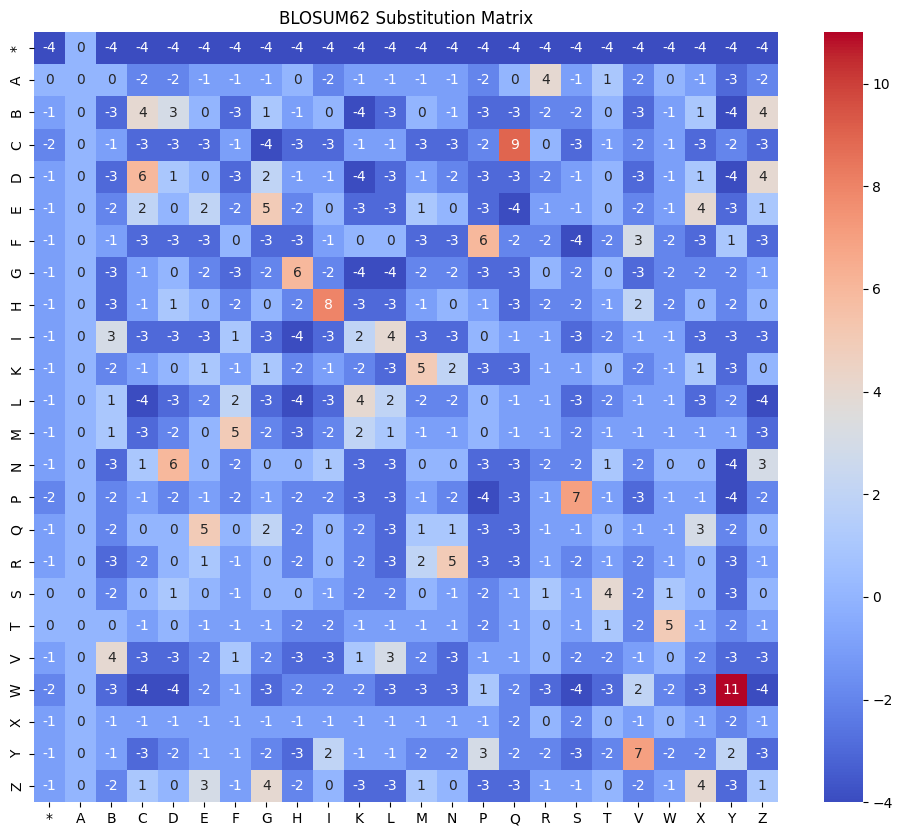

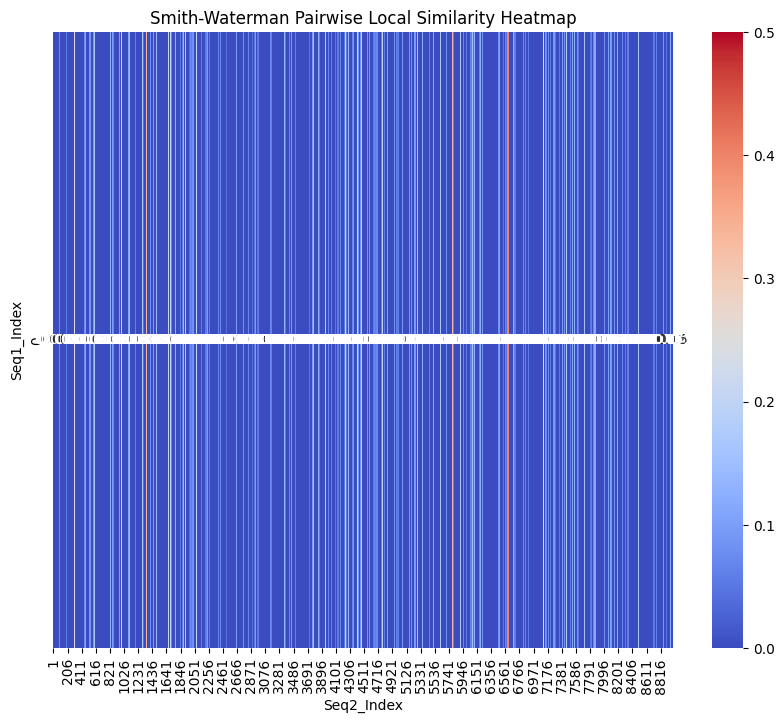

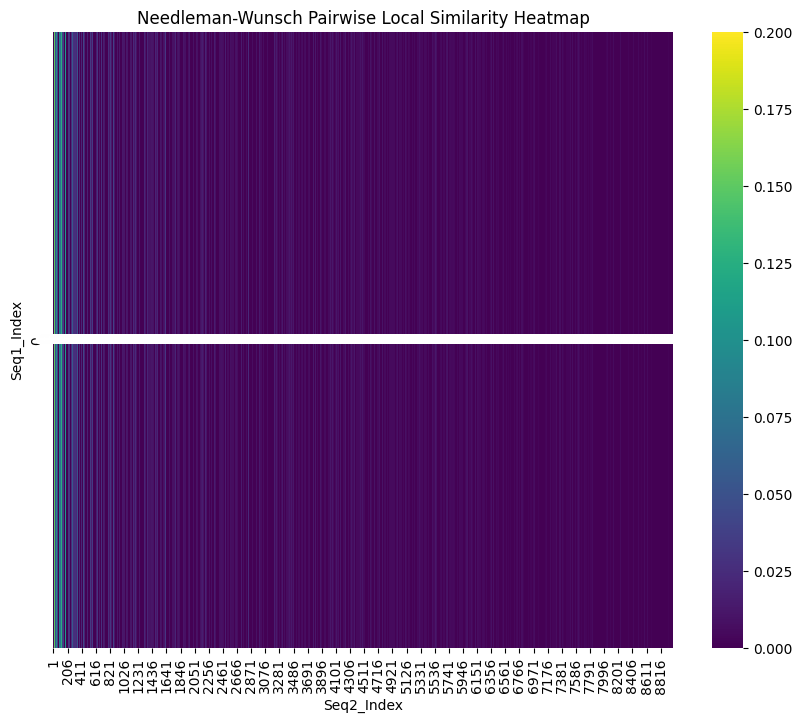

In [8]:

blosum62 = load_blosum62_matrix('/content/blosum62.csv')
sequences = read_sequences_from_csv('/content/protein_sequences.csv')


gap_penalty = -4
results_df = align_all_pairs(sequences, blosum62, gap_penalty, limit = 9000)


results_df.to_csv('alignment_results.csv', index=False)
print("Results saved to alignment_results.csv")
print(results_df.head())


visualize_substitution_impact(blosum62)
plot_sw_similarity_heatmap(results_df)
plot_nw_similarity_heatmap(results_df)